In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *



from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [9]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [10]:
import sys
sys.path.append('..')
from xDL.models.MaskedTransformer import MaskedTransformer
from xDL.utils.data_utils import *

In [11]:
EARLY_STOPPING = EarlyStopping(
        patience=25, restore_best_weights=True, min_delta=1e-05, monitor="val_loss"
    )

In [12]:
model = MaskedTransformer(
        data=data, 
        y="target",
        output_activation="linear",
        binning_task="regression",
        num_encoding="one_hot_constant",
        n_bins_num=50,
        batch_size=512,
        dropout=0.5,
        attn_dropout=0.5,
        ff_dropout=0.5,
        embedding_dim=64,
        masking="random",
        mask_prob=0.3
        )

--- Preprocessing ---


9it [00:00, 55.77it/s]

In [13]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},
    )


history = model.fit(
    model.training_dataset, 
    epochs=12, 
    validation_data=model.validation_dataset,
    callbacks=[EARLY_STOPPING],
    verbose=1,
)

In [21]:
model.encoder.masking_layers[2].mask_prob

0.3

In [22]:
model.encoder.masking_layers[2].counter

2

8it [00:00, 60.71it/s]


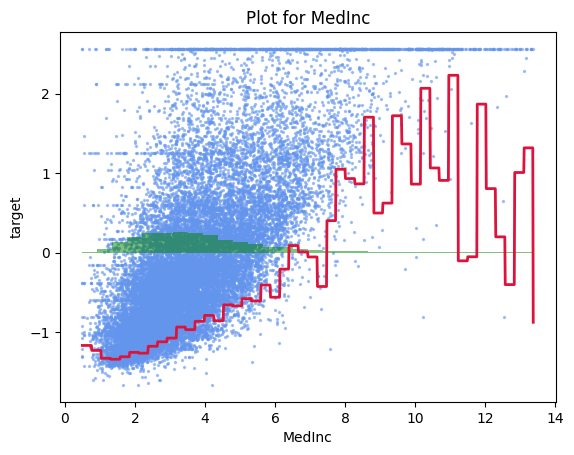

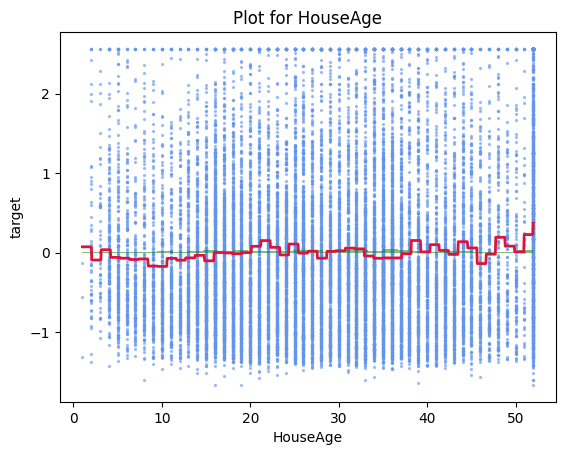

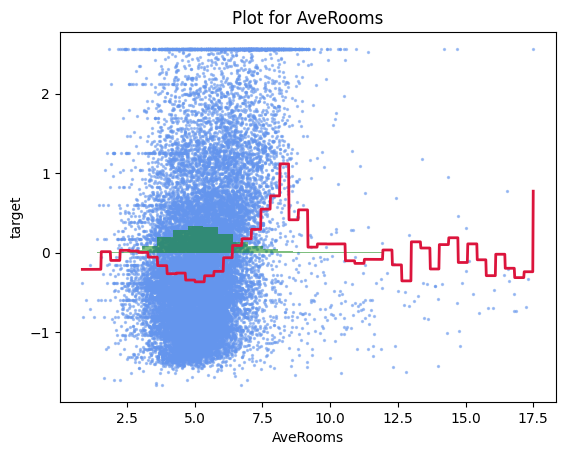

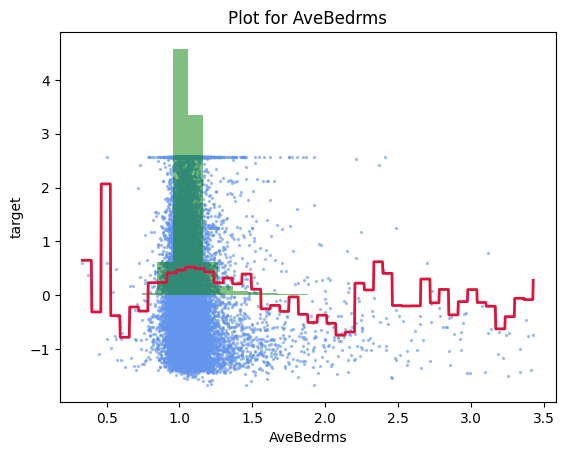

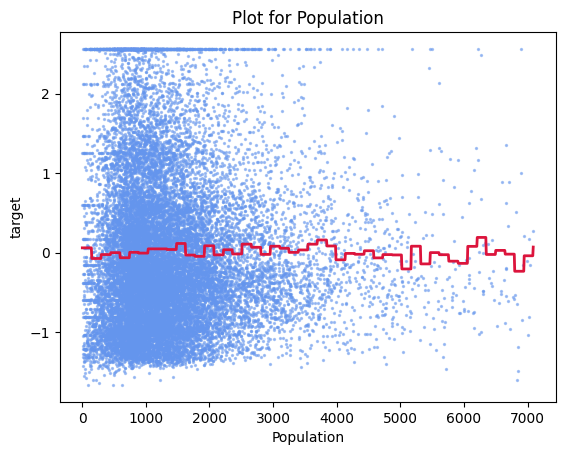

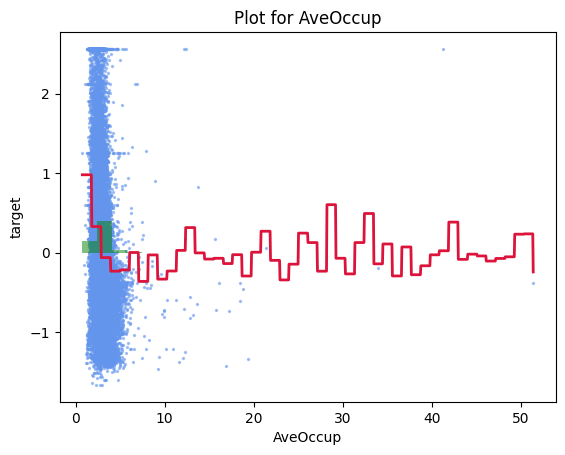

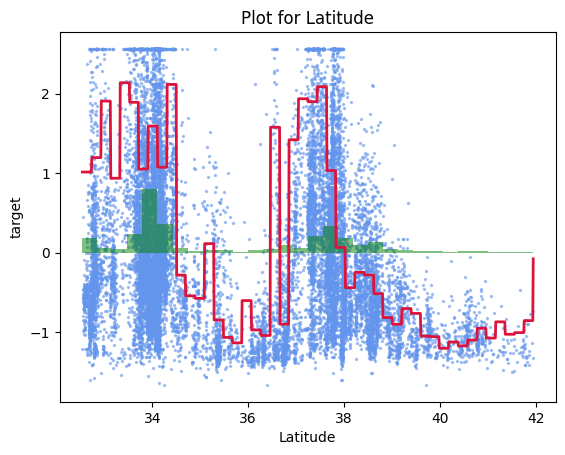

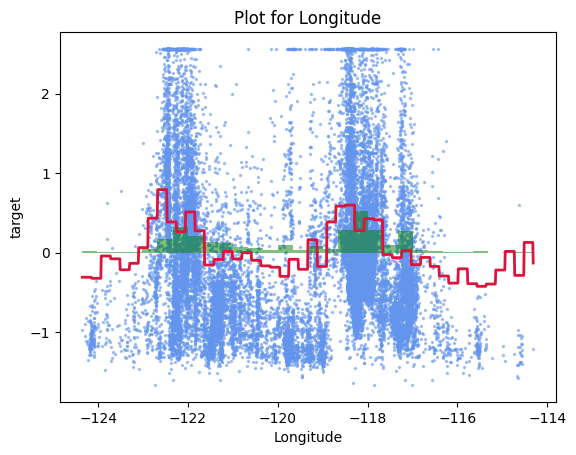

In [23]:
model.plot_features()

8it [00:00, 62.04it/s]


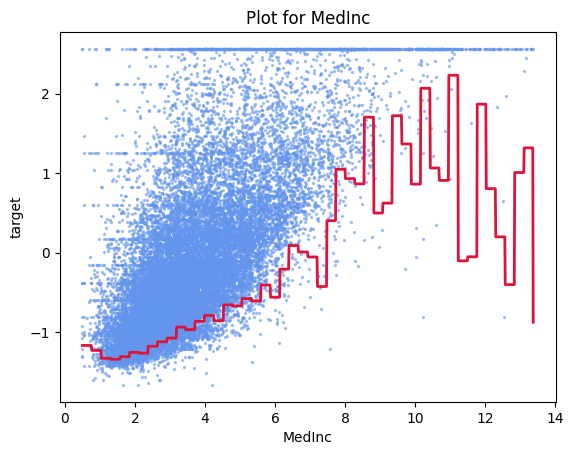

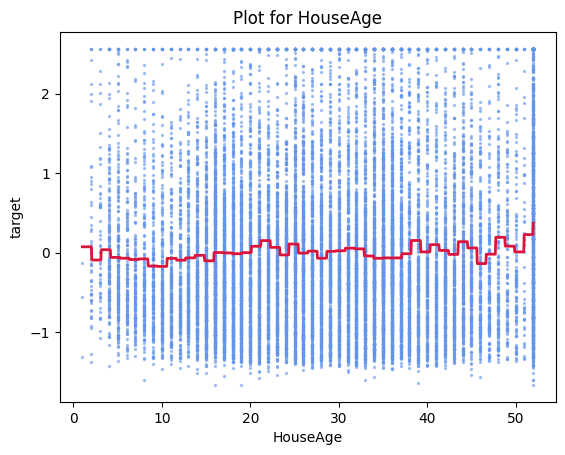

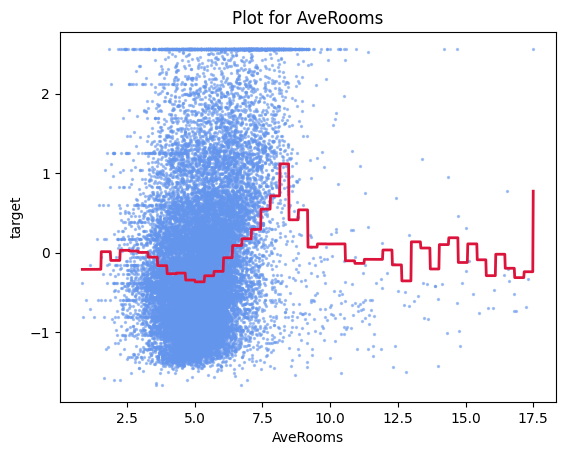

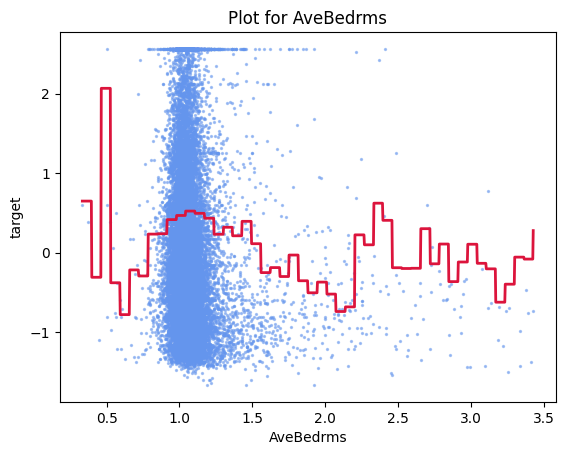

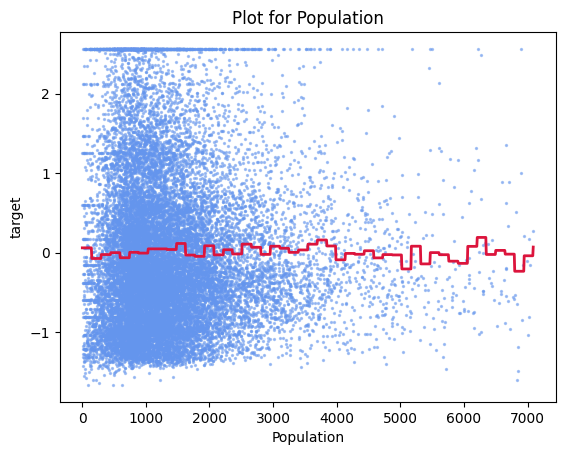

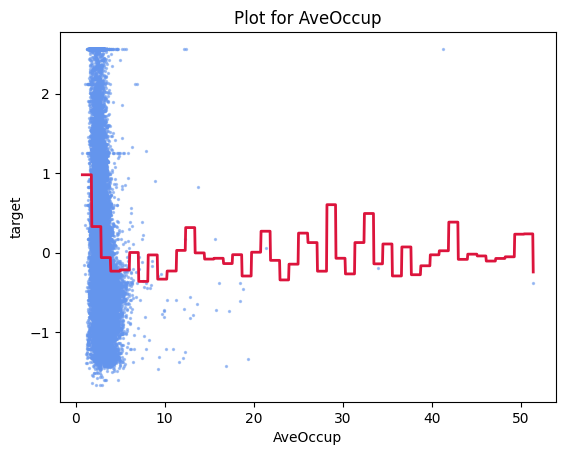

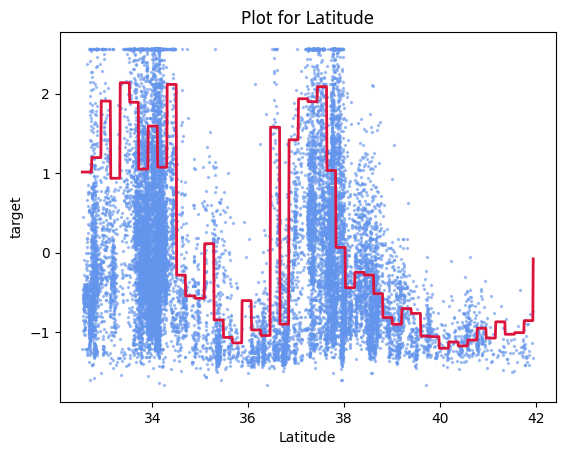

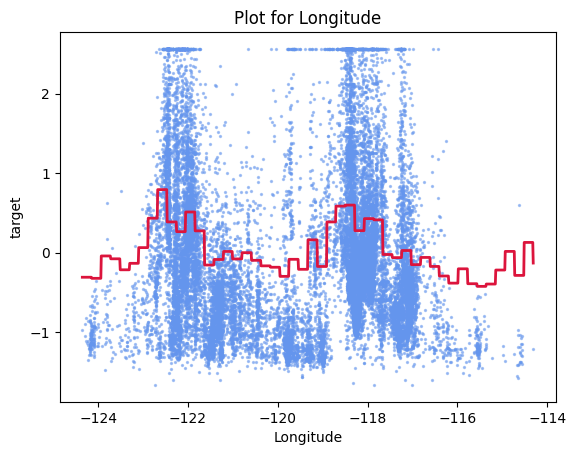

In [18]:
datasets, plotting_data = model.datamodule._generate_plotting_data_dense()

import matplotlib.pyplot as plt

# Get all columns except the target column
columns_to_plot = [col for col in data.columns if col != "target"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = model.predict(datasets[col], verbose=0)
    preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds), linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

In [19]:
model.evaluate(model.validation_dataset)

8/8 [==============================] - 2s 170ms/step - loss: 0.2700 - output_loss: 0.2700 - output_mse: 0.2700


[0.2699756324291229, 0.2699756324291229, 0.2699756324291229]

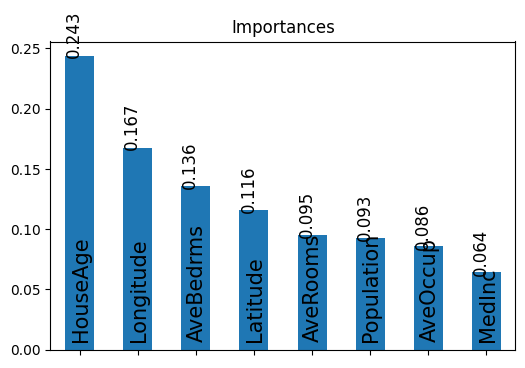

In [20]:
model.plot_importances()

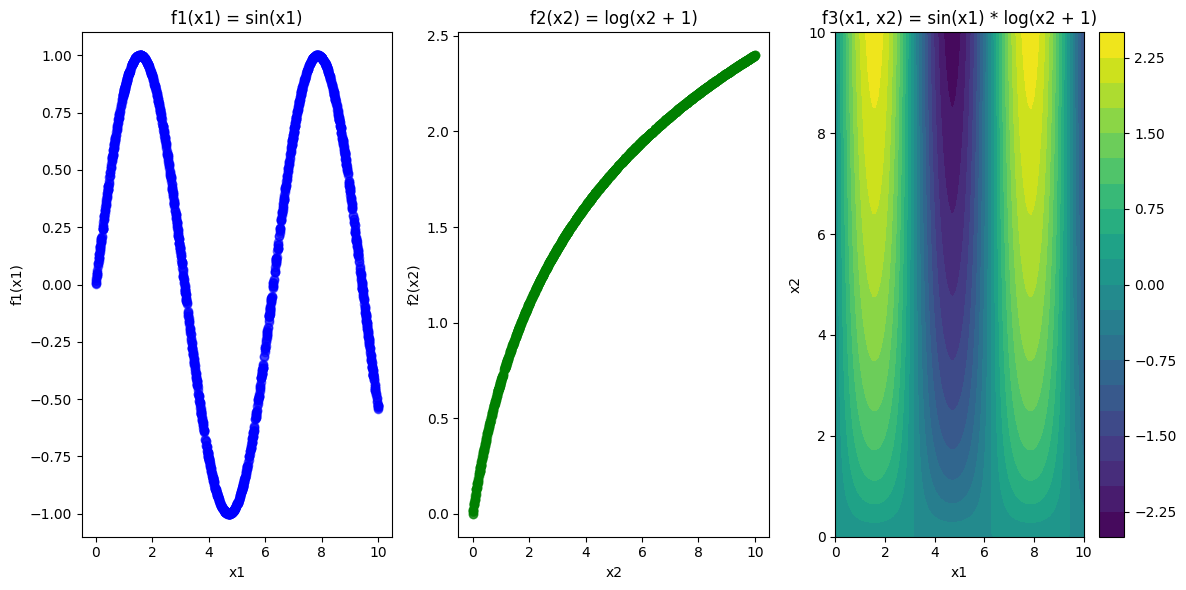

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the functions
def f1(x):
    return np.sin(x)

def f2(x):
    return np.log(x + 1)

def f3(x1, x2):
    return np.sin(x1) * np.log(x2 + 1)

# Simulate data
np.random.seed(0)
x1 = np.random.uniform(0, 10, 2000)
x2 = np.random.uniform(0, 10, 2000)
y = f1(x1) + f2(x2) + f3(x1, x2)

# Store in a DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

# Normalize y
scaler = MinMaxScaler()
df['y_normalized'] = scaler.fit_transform(df[['y']])

# Plotting
plt.figure(figsize=(12, 6))

# Plot f1
plt.subplot(1, 3, 1)
plt.scatter(x1, f1(x1), c='blue', alpha=0.5)
plt.title('f1(x1) = sin(x1)')
plt.xlabel('x1')
plt.ylabel('f1(x1)')

# Plot f2
plt.subplot(1, 3, 2)
plt.scatter(x2, f2(x2), c='green', alpha=0.5)
plt.title('f2(x2) = log(x2 + 1)')
plt.xlabel('x2')
plt.ylabel('f2(x2)')

# Plot f3 as a contour plot
plt.subplot(1, 3, 3)
x1_range = np.linspace(0, 10, 100)
x2_range = np.linspace(0, 10, 100)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
f3_grid = f3(x1_grid, x2_grid)
plt.contourf(x1_grid, x2_grid, f3_grid, levels=20, cmap='viridis')
plt.colorbar()
plt.title('f3(x1, x2) = sin(x1) * log(x2 + 1)')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()


In [44]:
df = df[["x1", "x2", "y"]]

In [51]:
model = MaskedTransformer(
        data=df, 
        y="y",
        output_activation="linear",
        binning_task="regression",
        num_encoding="int",
        n_bins_num=50,
        batch_size=512,
        dropout=0.5,
        attn_dropout=0.5,
        ff_dropout=0.5,
        embedding_dim=64,
        masking="random",
        mask_prob=0.7
        )

--- Preprocessing ---


0it [00:00, ?it/s]

3it [00:00, 80.65it/s]


In [52]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},
    )


history = model.fit(
    model.training_dataset, 
    epochs=50, 
    validation_data=model.validation_dataset,
    callbacks=[EARLY_STOPPING],
    verbose=1,
)

Epoch 1/50


1
2
3
4
4/4 [==============================] - 10s 450ms/step - loss: 8.1527 - output_loss: 8.1527 - output_mse: 8.1527 - val_loss: 7.8178 - val_output_loss: 7.8178 - val_output_mse: 7.8178
Epoch 2/50
4/4 [==============================] - 1s 170ms/step - loss: 7.1707 - output_loss: 7.1707 - output_mse: 7.1707 - val_loss: 6.0451 - val_output_loss: 6.0451 - val_output_mse: 6.0451
Epoch 3/50
4/4 [==============================] - 1s 168ms/step - loss: 5.3028 - output_loss: 5.3028 - output_mse: 5.3028 - val_loss: 3.5679 - val_output_loss: 3.5679 - val_output_mse: 3.5679
Epoch 4/50
4/4 [==============================] - 1s 164ms/step - loss: 4.1133 - output_loss: 4.1133 - output_mse: 4.1133 - val_loss: 3.7602 - val_output_loss: 3.7602 - val_output_mse: 3.7602
Epoch 5/50
4/4 [==============================] - 1s 163ms/step - loss: 4.3639 - output_loss: 4.3639 - output_mse: 4.3639 - val_loss: 3.6509 - val_output_loss: 3.6509 - val_output_mse: 3.6509
Epoch 6/50
4/4 [==========================

12it [00:00, 39.86it/s]


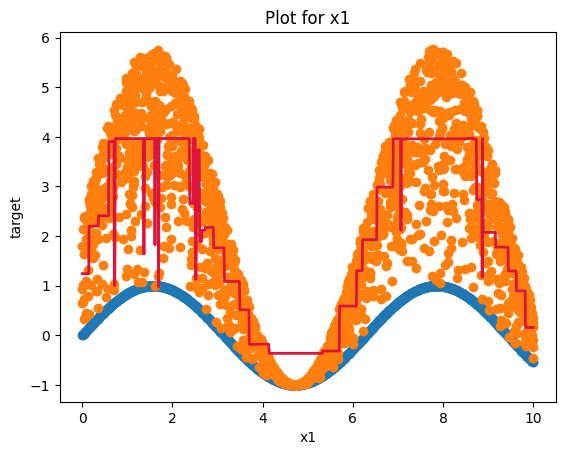

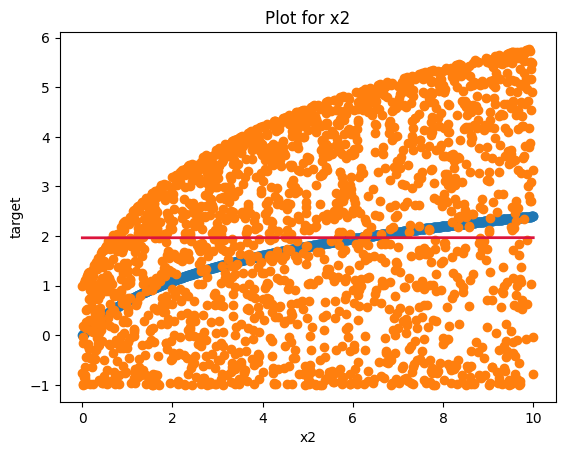

In [53]:
datasets, plotting_data = model.datamodule._generate_plotting_data_dense()

import matplotlib.pyplot as plt
data = df

# Get all columns except the target column
columns_to_plot = [col for col in data.columns if col != "y"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = model.predict(datasets[col], verbose=0)
    preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    if col == "x1":
        ax.scatter(plotting_data[col], f1(plotting_data[col]))
    elif col == "x2":
        ax.scatter(plotting_data[col], f2(plotting_data[col]))
    
    ax.plot(plotting_data[col], preds, linewidth=2, color="crimson")
    ax.scatter(data[col], data["y"])
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 